<a href="https://colab.research.google.com/github/AdamPeetz/PlaneGAN/blob/main/LatentInterpolationGenerator_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating GAN images: Interpolation of latent space 

 
 

The input of a generative model is a hypersphere of noise referred to as latent space. The generative network learns to map different points in latent space to features of the dataset it is trained on. Inputting the same point in latent space results in the same generated outcome.  

 
 

Points on a curve between areas of latent space can be fed into the model to create a smooth transition between two areas, interpolating the latent space of the model. 

In [ ]:
# load required libraries
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
from matplotlib import pyplot
import os, shutil 
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Support equations: Generating a hypersphere and points on the curve 

 
 

## generate_latent_points 

 
 

An input hypersphere is generated by creating a tensor with a random gausian distribution and n-dimensions.  

 
 

## slerp 

 
 

The distance between two points in a hypersphere is not linear, it is curved. The points along this line should be calculated using a spherical linear interpolation function called slerp. This function accounts for the curve in the sphere when generating datapoints. 

 
 

## interpolate_points 

 
 

Points are generated between two points in latent space which can be fed into the model to generate a smooth transition between two images. 

In [ ]:


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)

# Loading the generator: Importing a pretrained model 

 
 

A pretrained GAN model in .h5 format can be imported to create images. 

In [ ]:
# load model
model_location = '/content/gdrive/My Drive/planegan/test_models/dcgan_generator_model_350.h5' 

# model
model = load_model(model_location)

# Creating images: Wrapping it all together 

 
 

The functions above and the pretrained model can be used together to generate a sequence of images between points in latent space. Predictions are made by the model for each point along the curve. These predictions are rescaled and stacked into a 4-dimensional array containing all the generated images. This array can be iterated through, and the outputs saved to create a sequence of images in an output directory. 

60/60 [==============================] - 55s 911ms/step


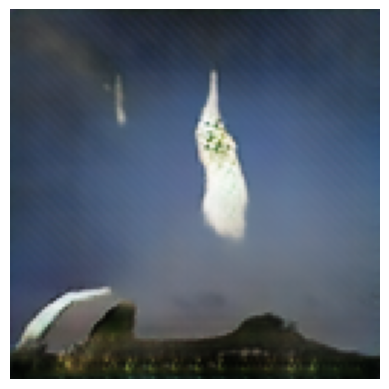

In [ ]:
# set random seed for reproducing results
# np.random.seed(0)

# number of interpolations to generate
n = 10

# number of steps in each interpolation
n_steps = 60

# generate latent points
pts = generate_latent_points(100, n)

# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1], n_steps)
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))

ila = 0
for pic in range(len(results)):
  ila+=1
  filename1 = '/content/gdrive/My Drive/planegan/test_models/sample_img_%01d.png' % (ila)
  # show single image
  pyplot.axis('off')
  pyplot.imshow(results[pic])
  pyplot.savefig(filename1)

Brownlee, Jason. (2019). Generative Adversarial Networks with Python. Machine Learning Mastery. EBook.